# Understanding CLIP image pipeline 
> Visualize image preprocessing steps and builds a pytorch custom Dataset to map image into embedding

- toc: true 
- badges: true
- comments: true
- categories: [image processing, clip model, dual encoder, PIL]

This post builds on top of the my [flicker 8k exploratory analysis post](https://thigm85.github.io/blog/flicker8k/dataset/image/nlp/2021/10/21/flicker8k-dataset-first-exploration.html).

In [1]:
import os

# sample images to use in this post
relevant_image_names = [
    '2610447973_89227ff978.jpg', 
    '3071676551_a65741e372.jpg', 
    '3365783912_e12c3510d8.jpg', 
    '3589367895_5d3729e3ea.jpg'
]

os.environ["IMG_DIR"] = "data/2021-10-22-understanding-clip-image-pipeline"

## Understanding CLIP image preprecessing

### CLIP image preprocessing pipeline

In [2]:
import clip

model, preprocess = clip.load("ViT-B/32")

We can take a look into the image pre-processing pipeline.

In [3]:
preprocess

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x10eaad1f0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

### Load files as PIL images

The CLIP preprocessing pipeline assumes we have a [PIL image](https://pillow.readthedocs.io/en/stable/reference/Image.html#the-image-class) as input, so that is what we will use to load images here. 

In [4]:
from PIL import Image

images = [Image.open(os.path.join(os.environ["IMG_DIR"], image_file_name)) for image_file_name in relevant_image_names]

In [5]:
import matplotlib.pyplot as plt

def plot_pil_images(images):
    assert len(images) == 4, "Number of images should be equal to 4"
    fig = plt.figure(figsize=(10, 10))
    for idx, image in enumerate(images):
        sub = fig.add_subplot(2,2,idx+1)
        imgplot = plt.imshow(image)
    plt.tight_layout()

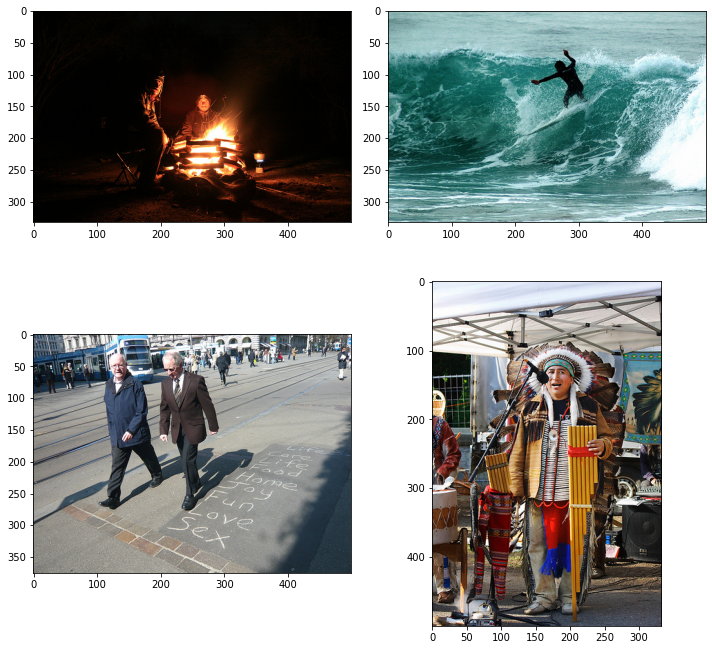

In [6]:
plot_pil_images(images)

### Resize

Resize the image so that the smaller of height and width have size 224. 

In [7]:
preprocess.transforms[0]

Resize(size=224, interpolation=PIL.Image.BICUBIC)

In [8]:
processed_images = [preprocess.transforms[0](image) for image in images]

The effect is hard to note by just looking at the images as the proportion of the images continues to be the same, but it is easy to see when we print the size of the tensors below.

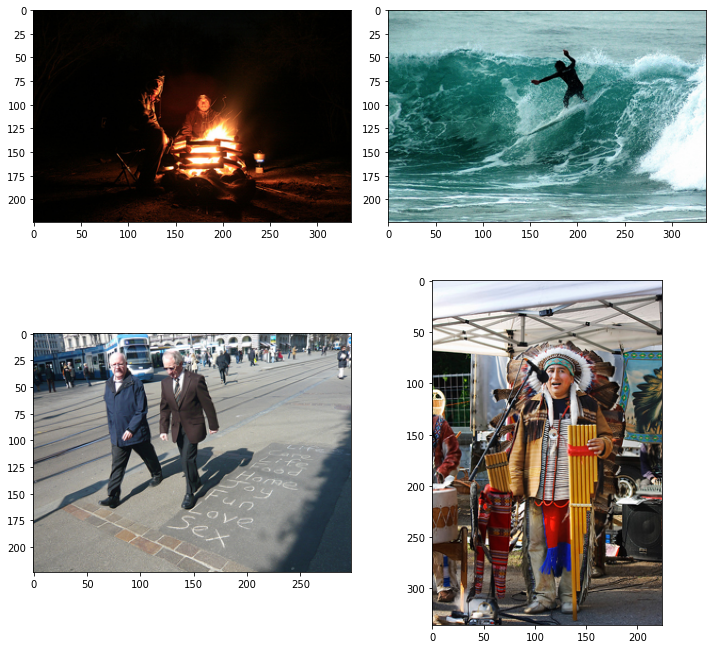

In [9]:
plot_pil_images(processed_images)

In [10]:
from torchvision.transforms import ToTensor

for idx, (original_image, processed_image) in enumerate(zip(images, processed_images)):
    print("Image {}:\nOriginal size: {}\nProcessed size:{}\n".format(idx+1, ToTensor()(original_image).shape, ToTensor()(processed_image).shape))

Image 1:
Original size: torch.Size([3, 333, 500])
Processed size:torch.Size([3, 224, 336])

Image 2:
Original size: torch.Size([3, 333, 500])
Processed size:torch.Size([3, 224, 336])

Image 3:
Original size: torch.Size([3, 375, 500])
Processed size:torch.Size([3, 224, 298])

Image 4:
Original size: torch.Size([3, 500, 333])
Processed size:torch.Size([3, 336, 224])



### CenterCrop

Crop the center of the image such that the resulting images has size (224, 224)

In [11]:
preprocess.transforms[1]

CenterCrop(size=(224, 224))

In [12]:
processed_images = [preprocess.transforms[1](image) for image in processed_images]

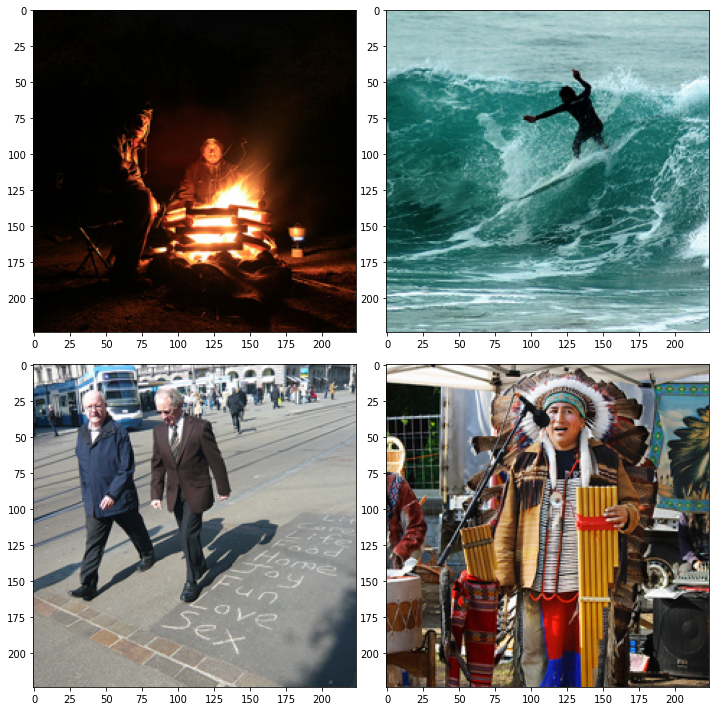

In [13]:
plot_pil_images(processed_images)

### Convert to RGB

In [14]:
preprocess.transforms[2]

<function clip.clip._convert_image_to_rgb(image)>

This transform [convert the image to RGB model](https://github.com/openai/CLIP/blob/main/clip/clip.py#L71-L72). Since the images are already formatted with RGB encoding we will not see any difference.

In [15]:
from torch import equal

equal(ToTensor()(preprocess.transforms[2](processed_images[0])), ToTensor()(processed_images[0]))

True

But we will apply this transform for completeness:

In [16]:
processed_images = [preprocess.transforms[2](image) for image in processed_images]

### Convert PIL image to Tensor

In [17]:
preprocess.transforms[3]

ToTensor()

In [18]:
processed_images = [preprocess.transforms[3](image) for image in processed_images]

We now have tensors:

In [19]:
print([x.shape for x in processed_images])

[torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([3, 224, 224])]


### Normalize

Normalize will subtract the mean and divide by the standard deviation. The is one mean and one standard deviation for each of the three channels available.

In [20]:
preprocess.transforms[4]

Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))

In [21]:
processed_images = [preprocess.transforms[4](image) for image in processed_images]

After the normalization the processed images are quite different from the original images.

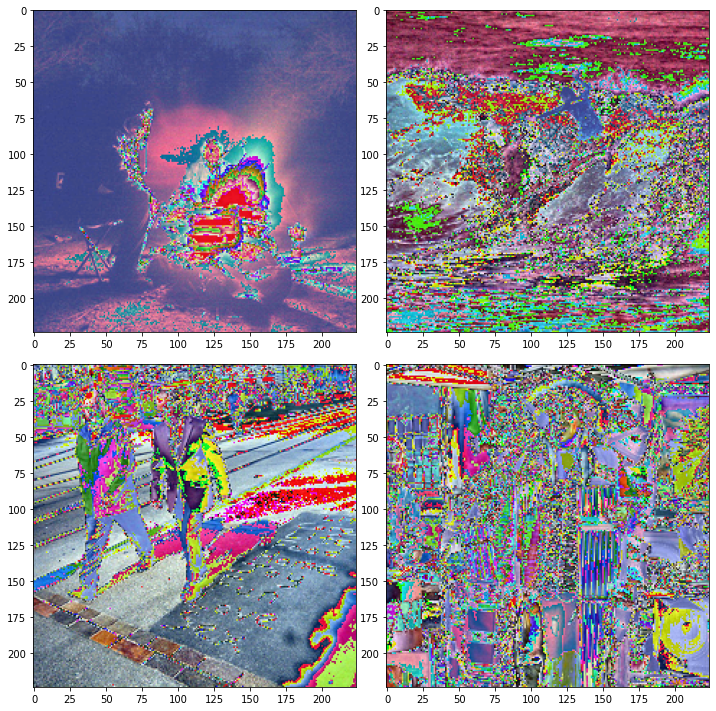

In [22]:
from torchvision.transforms import ToPILImage

plot_pil_images([ToPILImage()(x) for x in processed_images])

## Create embedding from processed images

Stack the four processed images on top of each other.

In [23]:
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_input = torch.tensor(np.stack(processed_images)).to(device)

In [24]:
image_input.shape

torch.Size([4, 3, 224, 224])

Generate the image vectors. Each vector have 512 elements.

In [25]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

In [26]:
image_features.shape

torch.Size([4, 512])

Use `unsqueeze(0)` if you want to apply the encoder to one image as it expected a 4D Tensor.

In [27]:
with torch.no_grad():
    image_features = model.encode_image(processed_images[0].unsqueeze(0))

In [28]:
image_features.shape

torch.Size([1, 512])

## Create ImageDataset

Create a custom Dataset that loads an image and optionally apply a transform function to it.

In [29]:
import os
import glob
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_file_names = glob.glob(os.path.join(img_dir, "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        image_file_name = self.image_file_names[idx]
        image = Image.open(image_file_name)
        if self.transform:
            image = self.transform(image)
        return image

Here is how it looks without applying and `transform` function to it:

In [30]:
image_dataset = ImageDataset(img_dir=os.environ["IMG_DIR"])

Each iteration returns one of the original images:

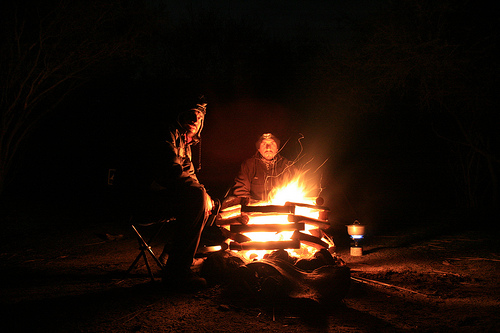

In [31]:
next(iter(image_dataset))

### Apply the pre-processing image pipeline

In [32]:
image_dataset = ImageDataset(img_dir=os.environ["IMG_DIR"], transform=preprocess)

It returns the processed Tensor when we apply the preprocess pipeline:

In [33]:
next(iter(image_dataset)).shape

torch.Size([3, 224, 224])

### Apply the image encoder

In [34]:
def from_image_to_vector(x, process_fn):
    with torch.no_grad():
        image_features = model.encode_image(process_fn(x).unsqueeze(0))    
    return image_features

In [35]:
image_dataset = ImageDataset(
    img_dir=os.environ["IMG_DIR"], 
    transform=lambda x: from_image_to_vector(x, process_fn=preprocess)
)

Now the dataset returns a 512-dimensional vector associated with a specific image.

In [36]:
next(iter(image_dataset)).shape

torch.Size([1, 512])

In [37]:
from torch.utils.data import DataLoader

image_dataloader = DataLoader(image_dataset, batch_size=64, shuffle=False)